In [21]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from helper import fields, interface, fields_original, from_matrix, RealWave
from fio import readin
working_dir = '/home/jiarong/research/projects/windwave/rerun/'
import matplotlib as mpl
from case import Case
mpl.style.use('pof')

In [309]:
from scipy.interpolate import griddata
import gc
from scipy.special import gamma
from scipy.signal import hilbert
from scipy.signal import butter, filtfilt

class Interface1D():
    """Class for every interface related 1D output. Unstructured grid input.
            
    Attributes:
        xarray: equal distanced x grid 
        <field>data: row data of <field>
        <field>: interpolated data of <field>, including eta/p/grad/dudy/uxw...    
    """
     
    def __init__(self, L0, N, path, t, PRUNING=True, pre='/field/eta_loc_t'):
        """Example of docstring on the __init__ method.

        The __init__ method may be documented in either the class level
        docstring, or as a docstring on the __init__ method itself.

        Either form is acceptable, but the two should not be mixed. Choose one
        convention to document the __init__ method and be consistent with it.

        Note:
            Do not include the `self` parameter in the ``Args`` section.

        Args:
            L0, N: The desired output grid number
            working_dir: The case's directory
            t: Time of this eta file.
            PRUNING: If eta is output by multiple processes and have multiple headers
                    (only applicable to MPI processed file).  
            pre: the prefix of the desirable data file.
        """
        self.L0 = L0; self.N = N; self.t = t
        self.xarray = np.linspace(-self.L0/2.,self.L0/2.,self.N,endpoint=False)+self.L0/2**self.N/2 # Centered grid for interpolation
        filename = path + pre + '%g' %self.t
        snapshot = pd.read_table(filename, delimiter = ',')
        snapshot = snapshot.sort_values(by = ['x'])
        # Field entries
        # x,pos,epsilon,p,p_p1,p_p2,dudy1,dudy2,dvdx1,dvdx2,dudx1,dudx2,dvdy1,dvdy2,uxa,uya,uxw,uyw
        if PRUNING:
            snapshot = snapshot[snapshot.x != 'x']
            snapshot = snapshot.astype('float')
            snapshot = snapshot[snapshot.pos < 0.4/(2*np.pi)] # Exclude data over slope 0.4
            
        self.xdata = np.array(snapshot.x, dtype=float)
        self.etadata = np.array(snapshot.pos, dtype=float)
        self.pdata = np.array(snapshot.p_p1, dtype=float)
        self.graddata = np.array(snapshot.epsilon, dtype=float)
        self.dudydata = np.array(snapshot.dudy1, dtype=float)
        self.dvdxdata = np.array(snapshot.dvdx1, dtype=float)
        self.dudxdata = np.array(snapshot.dudx1, dtype=float)
        self.dvdydata = np.array(snapshot.dvdy1, dtype=float)
        self.uxwdata = np.array(snapshot.uxw, dtype=float)
        self.uywdata = np.array(snapshot.uyw, dtype=float)
        self.delta = np.array(snapshot.delta, dtype=float)
        del (snapshot); gc.collect()  # Only necessary for 2D for memory issue              
        
        # Interpolate over x, 'nearest' is used to ensure that none of the interpolated point is 'nan' 
        self.eta = griddata(self.xdata.ravel(), self.etadata.ravel(), self.xarray, method='nearest')
        self.p = griddata(self.xdata.ravel(), self.pdata.ravel(), self.xarray, method='nearest')
        self.dudy = griddata(self.xdata.ravel(), self.dudydata.ravel(), self.xarray, method='nearest')
        self.dvdx = griddata(self.xdata.ravel(), self.dvdxdata.ravel(), self.xarray, method='nearest')
        self.dudx = griddata(self.xdata.ravel(), self.dudxdata.ravel(), self.xarray, method='nearest')
        self.dvdy = griddata(self.xdata.ravel(), self.dvdydata.ravel(), self.xarray, method='nearest')
        self.grad = griddata(self.xdata.ravel(), self.graddata.ravel(), self.xarray, method='nearest')
        self.uxw = griddata(self.xdata.ravel(), self.uxwdata.ravel(), self.xarray, method='nearest')
        self.uyw = griddata(self.xdata.ravel(), self.uywdata.ravel(), self.xarray, method='nearest')
    
    def __butter_lowpass_filter(self, data, CUT=4):
        """A helper function that performs lowpass filtering."""
        T = 1           # Sample Period
        fs = self.N        # Sample rate, Hz (should be the xarray size)
        cutoff = CUT    # desired cutoff frequency of the filter, Hz
        nyq = 0.5 * fs  # Nyquist Frequency
        order = 4       # sin wave can be approximately represented as quadratic
        n = int(T * fs) # total number of samples
        normal_cutoff = cutoff / nyq
        # Get the filter coefficients 
        b, a = butter(order, normal_cutoff, btype='low', analog=False)
        y = filtfilt(b, a, data)
        return y
    
    def uwater(self, c, ustar, omega, Re):
        """ Water velocity decomposition.
            Dependency: gamma from scipy.special, hilbert from scipy.signal
            
            Args:
                c: wave speed (analyical from case.wave.c)
                ustar: u*/c (from case.ustar)
                omega: omega (from case.wave.omega)
                Re: Re (from case.Re)
                
            Attributes:
                uxw_smooth: smoothed direct output of uxw
                uyw_smooth: smoothed direct output of uyw
                eta_smooth
                phase
                ux_orbit: orbital velocity from eta_smooth, u component (simplest estimation)
                uy_orbit: orbital velocity from eta_smooth, v component
                ud: uxw_smooth - ux_orbit, approximate drift velocity (phase dependent)
                ud_analy: analytical time dependent drift, constant along x
                uxw_analy: ud_analy + ux_orbit
        """
        
        # Smooth out simulation output water velocity
        self.uxw_smooth = self.__butter_lowpass_filter(self.uxw, CUT=8)
        self.uyw_smooth = self.__butter_lowpass_filter(self.uyw, CUT=8)

        # The analytical water velocity
        self.eta_smooth = self.__butter_lowpass_filter(self.eta, CUT=8)
        analytic_signal = hilbert(self.eta_smooth)
        self.phase = np.unwrap(np.angle(analytic_signal))
        self.ux_orbit = self.eta_smooth*c*2*np.pi
        self.uy_orbit = self.eta_smooth*c*2*np.pi/np.cos(self.phase)*np.cos(self.phase-np.pi/2)        
        self.ud = self.uxw_smooth - self.ux_orbit
        self.ud_analy = self.t**0.5*gamma(1)/gamma(3/2)/850 * (ustar*c)**2 * (2*np.pi/omega/(1/Re))**0.5 # Drift according to theoretical solution
        self.uxw_analy = self.ud_analy + self.ux_orbit
        
    def stress(self, tau0, mu_a):
        """
            Args:
                tau0: the set total stress
                mu_a: the air dynamic viscosity
                
            Attributes:
                tau0: rho u_*^2 from given
                p, p_smooth: the original p subtracted by average and smoothed p              
                tau_nux, tau_nuy:
                tau_nux_smooth, tau_nuy_smooth:
        """
        # Pressure
        self.tau0 = tau0
        self.p = self.p-np.average(self.p) # Subtract mean
        self.p_smooth = self.__butter_lowpass_filter(self.p, CUT=8) # The cut frequency is pretty hight to capture rapid change
        
        # Shear stress
        # Take also dvdx into account
        # tau_nux1 = self.__butter_lowpass_filter(self.dudy_tile, CUT=4)*mu_a
        self.tau_nux = (self.dudy+self.dvdx)*mu_a 
        self.tau_nux_smooth = self.__butter_lowpass_filter(self.tau_nux, CUT=8)
        self.tau_nuy = 2*self.dvdy*mu_a
        self.tau_nuy_smooth = self.__butter_lowpass_filter(self.tau_nuy, CUT=8)
        
    def vis(self):
        """Visualize velocity and stress. Can only be run after uwater and stress are both run."""
        plt.figure(figsize=[4,6])
        
        # Plot water velocity in axis1
        ax1 = plt.subplot(311)       
        ax1.plot(self.xdata, self.uxwdata, c='C0', alpha = 0.5) # Water velocity uxw unfiltered 
        ax1.plot(self.xdata, self.uywdata, c='C1', alpha = 0.5) # Water velocity uyw unfiltered
        ax1.plot(self.xarray, self.uxw_smooth, c='C0', label = '$u_s$') # Water velocity uxw smoothed 
        ax1.plot(self.xarray, self.uyw_smooth, c='C1', label = '$v_s$') # Water velocity uyw smoothed         
        ax1.plot(self.xarray, self.ux_orbit, '--', c='C2', label='$u_{orbit}$', alpha = 0.5) # Orbital velocity u analytical
        ax1.plot(self.xarray, self.uy_orbit, '--', c='C1', label='$v_{orbit}$', alpha = 0.5) # Orbital velocity v analytical
        ax1.plot(self.xarray, self.uxw_analy, '--', c='C0', label = '$u_{orbit}$ + $u_d$', alpha = 0.5)
        ax1.plot(self.xarray, self.eta_smooth, c='gray', alpha = 0.5)
        ax1.set_xlabel(r'$x/\lambda$')
        ax1.set_ylabel(r'$u_s,v_s$')
        ax1.set_xlim([-0.5,0.5])
        ax1.set_ylim([-0.05,0.1])
#         ax1.legend(bbox_to_anchor=(1.02, 0.5), loc = 'center left')   
        ax1.legend()   
        
        # Plot pressure in axis2
        ax2 = plt.subplot(312)
        ax2.plot(self.xarray, self.p/self.tau0, alpha=0.5) # Pressure
        ax2.plot(self.xarray, self.p_smooth/self.tau0, c='C0') # Pressure smoothed
        ax2.plot(self.xarray, self.eta_smooth*50, c='gray', alpha = 0.5)
        ax2.set_xlim([-0.5,0.5])
        ax2.set_ylim([-10,10])
        ax2.set_xlabel(r'$x/\lambda$'); ax2.set_ylabel(r'$p/\rho_a u_*^2$')
        ax2.legend()   
        
        # Plot shear stress in axis 3
        ax3 = plt.subplot(313)
        ax3.plot(self.xarray, self.tau_nux/tau0, alpha = 0.5) 
        ax3.plot(self.xarray, self.tau_nux_smooth/tau0, c='C0',
                 label = r'$\tau_{\nu x} = \mu_a (\frac{\partial u}{\partial y}+\frac{\partial v}{\partial x})$') 
        ax3.plot(self.xarray, self.tau_nuy/tau0, alpha = 0.5) 
        ax3.plot(self.xarray, self.tau_nuy_smooth/tau0, c='C1',
                 label = r'$\tau_{\nu y} = 2 \mu_a \frac{\partial v}{\partial y}$') 
        ax3.plot(self.xarray, self.eta_smooth*10, c='gray', alpha = 0.5)
        ax3.set_xlim([-0.5,0.5])
        ax3.set_ylim([-0.5,2])
        ax3.set_xlabel(r'$x/\lambda$'); ax3.set_ylabel(r'$\tau_\nu/\rho_a u_*^2$')
        ax3.legend()
#         return (ax1,ax2,ax3)
        
    def integrate(self):
        """Compute the phase average input terms.
        
            Attributes:
                S_taunu: total input from shear stress (from smoothed)
                S_taunu_err: total input from shear stress unsmoothed, for error bar
                S_taunu_w: approximate sub part of S_taunu from wave, computed using ux_orbit uy_orbit
                S_taunu_d: appreximate sub part of S_taunu from drift 
        """
        self.S_taunu = np.sum(self.tau_nux_smooth*self.uxw_smooth+self.tau_nuy_smooth*self.uyw_smooth)*self.L0/self.N
        self.S_taunu_err = np.sum(self.tau_nux*self.uxw+self.tau_nuy*self.uyw)*self.L0/self.N #For error bar
        self.S_taunu_w = np.sum(self.tau_nux_smooth*self.ux_orbit+self.tau_nuy_smooth*self.uy_orbit)*self.L0/self.N 
        self.S_taunu_d = np.sum(self.tau_nux_smooth*self.ud)*self.L0/self.N
        self.S_p = np.sum(-self.p_smooth*self.uyw_smooth)*self.L0/self.N #NOTE: this is only the first order approximation!
        self.S_p_err = np.sum(-self.p*self.uyw)*self.L0/self.N #Might need to add the metrics and uxw
                                                                         
        
    def interval_average():
        # How to do interval average of the above calculation
        pass

In [310]:
"""Loop through different u_*/c, Re and time t and compute tau_wave"""

'Loop through different u_*/c, Re and time t and compute tau_wave'

In [311]:
case.__dict__

{'ustar': 0.6,
 'ak': 0.05,
 'Bo': 1.47,
 'Re': 10660,
 'LEVEL': 11,
 'L0': 1.0,
 'g': 1.0,
 'k': 6.283185307179586,
 'rho1': 1,
 'rho2': 0.001176470588235294,
 'path': '/home/jiarong/research/projects/windwave/rerun/linear_wavewind_rerun_test_Ustar0.6ak0.05Bo1.47Re10660.LEVEL11',
 'wave': <helper.RealWave at 0x7fd8b7d9dfd0>,
 'availt': 96}

In [402]:
case1 = Case(ustar=1, ak=0.05, Bo=200, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
                   working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case2 = Case(ustar=1, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
                   working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case3 = Case(ustar=0.6, ak=0.05, Bo=200, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
                   working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case4 = Case(ustar=0.6, ak=0.05, Bo=1.47, Re=10660, LEVEL=11, L0=1., g=1., k=2.*np.pi,
                   working_dir = '/home/jiarong/research/projects/windwave/rerun/', prefix = 'linear_wavewind_rerun_test_')
case = case1
interface_ensem = []
t = []
ak = [] # time sequence of ak
S_taunu_ensem = [] 
S_taunu_w_ensem = [] 
S_taunu_d_ensem = [] 
S_taunu_err_ensem = []
S_p_ensem = []
S_p_err_ensem = []
tau0 = case.rho2*(case.wave.c*case.ustar)**2
mu_a = 1/case.Re*(17.4e-6/8.9e-4)

for i in range(1,96):
    t.append(i/32)
    interface = Interface1D(1, 256, case.path, i/32, PRUNING=False, pre='/field/eta_loc_t')
    interface.uwater(case.wave.c, case.ustar, case.wave.omega, case.Re) 
    interface.stress(tau0, mu_a); interface.integrate()
    S_taunu_ensem.append(interface.S_taunu)
    S_taunu_err_ensem.append(interface.S_taunu_err)
    S_taunu_w_ensem.append(interface.S_taunu_w) 
    S_taunu_d_ensem.append(interface.S_taunu_d)   
    S_p_ensem.append(interface.S_p)
    S_p_err_ensem.append(interface.S_p_err)
    interface_ensem.append(interface)
    ak.append(np.std(interface.eta)*2*np.pi*2**0.5)

t = np.array(t)
S_taunu_ensem = np.array(S_taunu_ensem)
S_p_ensem = np.array(S_p_ensem)

In [389]:
np.std(interface_ensem[0].eta)*2*np.pi*2**0.5

0.05012572679026041

(-0.2, 1.2)

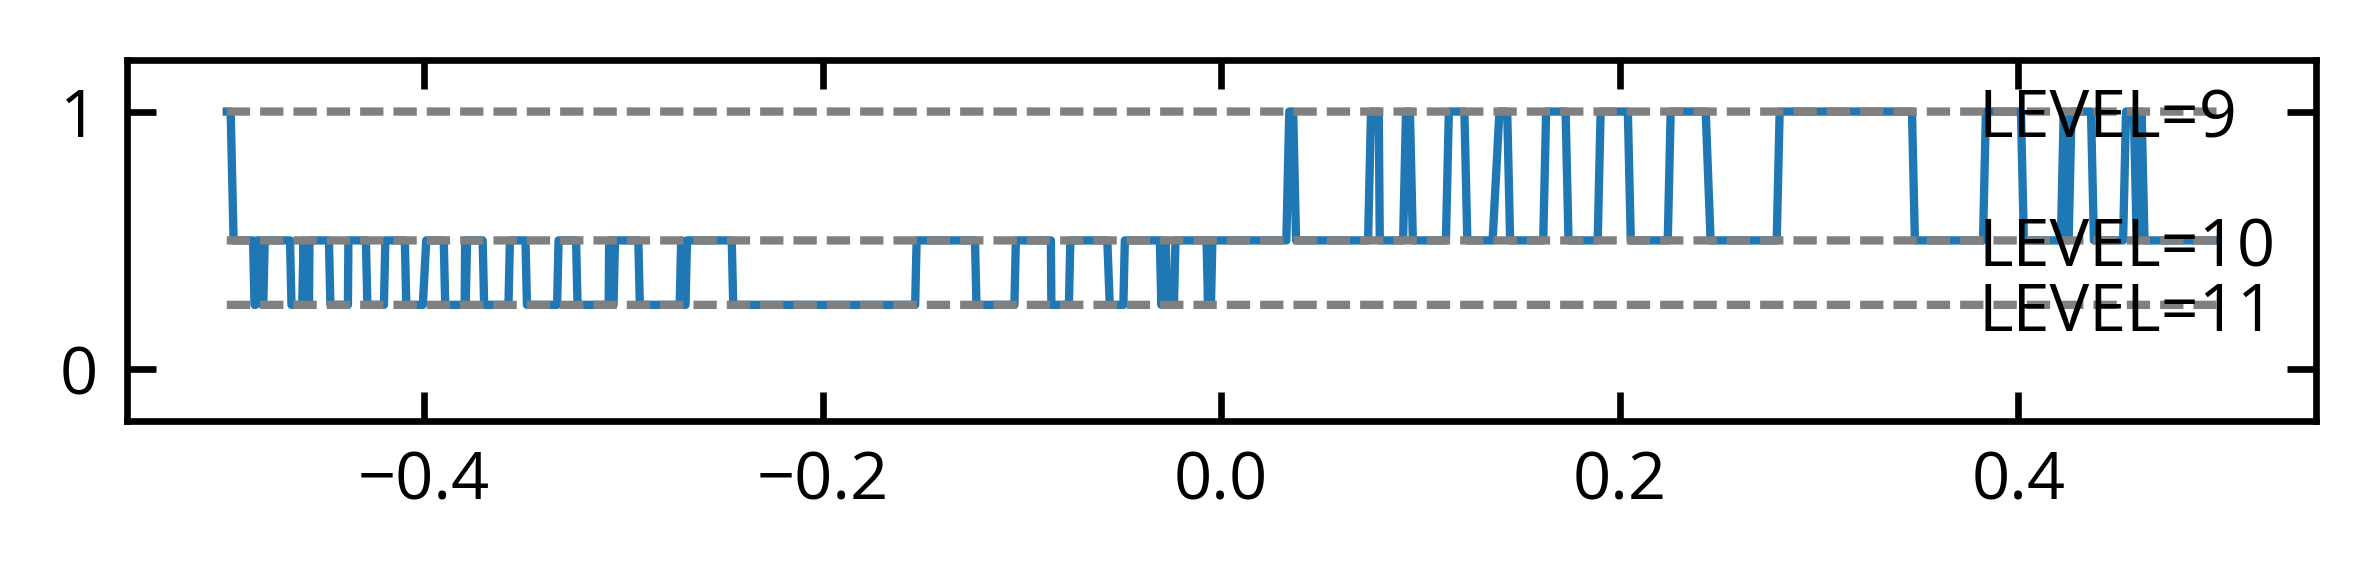

In [403]:
"""Check all the output cell refinement level."""
plt.figure(figsize=[4,1])
plt.plot(interface_ensem[90].xdata, interface_ensem[90].delta*512, lw = 1)
plt.plot(interface_ensem[90].xdata, interface_ensem[90].xdata/interface_ensem[90].xdata*0.5, '--', c='gray', lw = 1)
plt.plot(interface_ensem[90].xdata, interface_ensem[90].xdata/interface_ensem[90].xdata*0.25, '--', c='gray', lw = 1)
plt.plot(interface_ensem[90].xdata, interface_ensem[90].xdata/interface_ensem[90].xdata, '--', c='gray', lw = 1)
plt.text(0.38, 0.15, 'LEVEL=11')
plt.text(0.38, 0.4, 'LEVEL=10')
plt.text(0.38, 0.9, 'LEVEL=9')
plt.ylim([-0.2,1.2])

In [314]:
S_p_err_ensem - S_p_ensem

array([-2.74002543e-09, -2.40475257e-08, -8.61166992e-09, -2.05631600e-08,
       -6.72718947e-09,  8.03336116e-10,  1.14538132e-08,  7.99091091e-09,
        2.56681078e-08,  2.91351919e-08,  3.78578406e-08,  9.52675682e-08,
        2.47167738e-07,  4.76999088e-08,  4.15221866e-08])

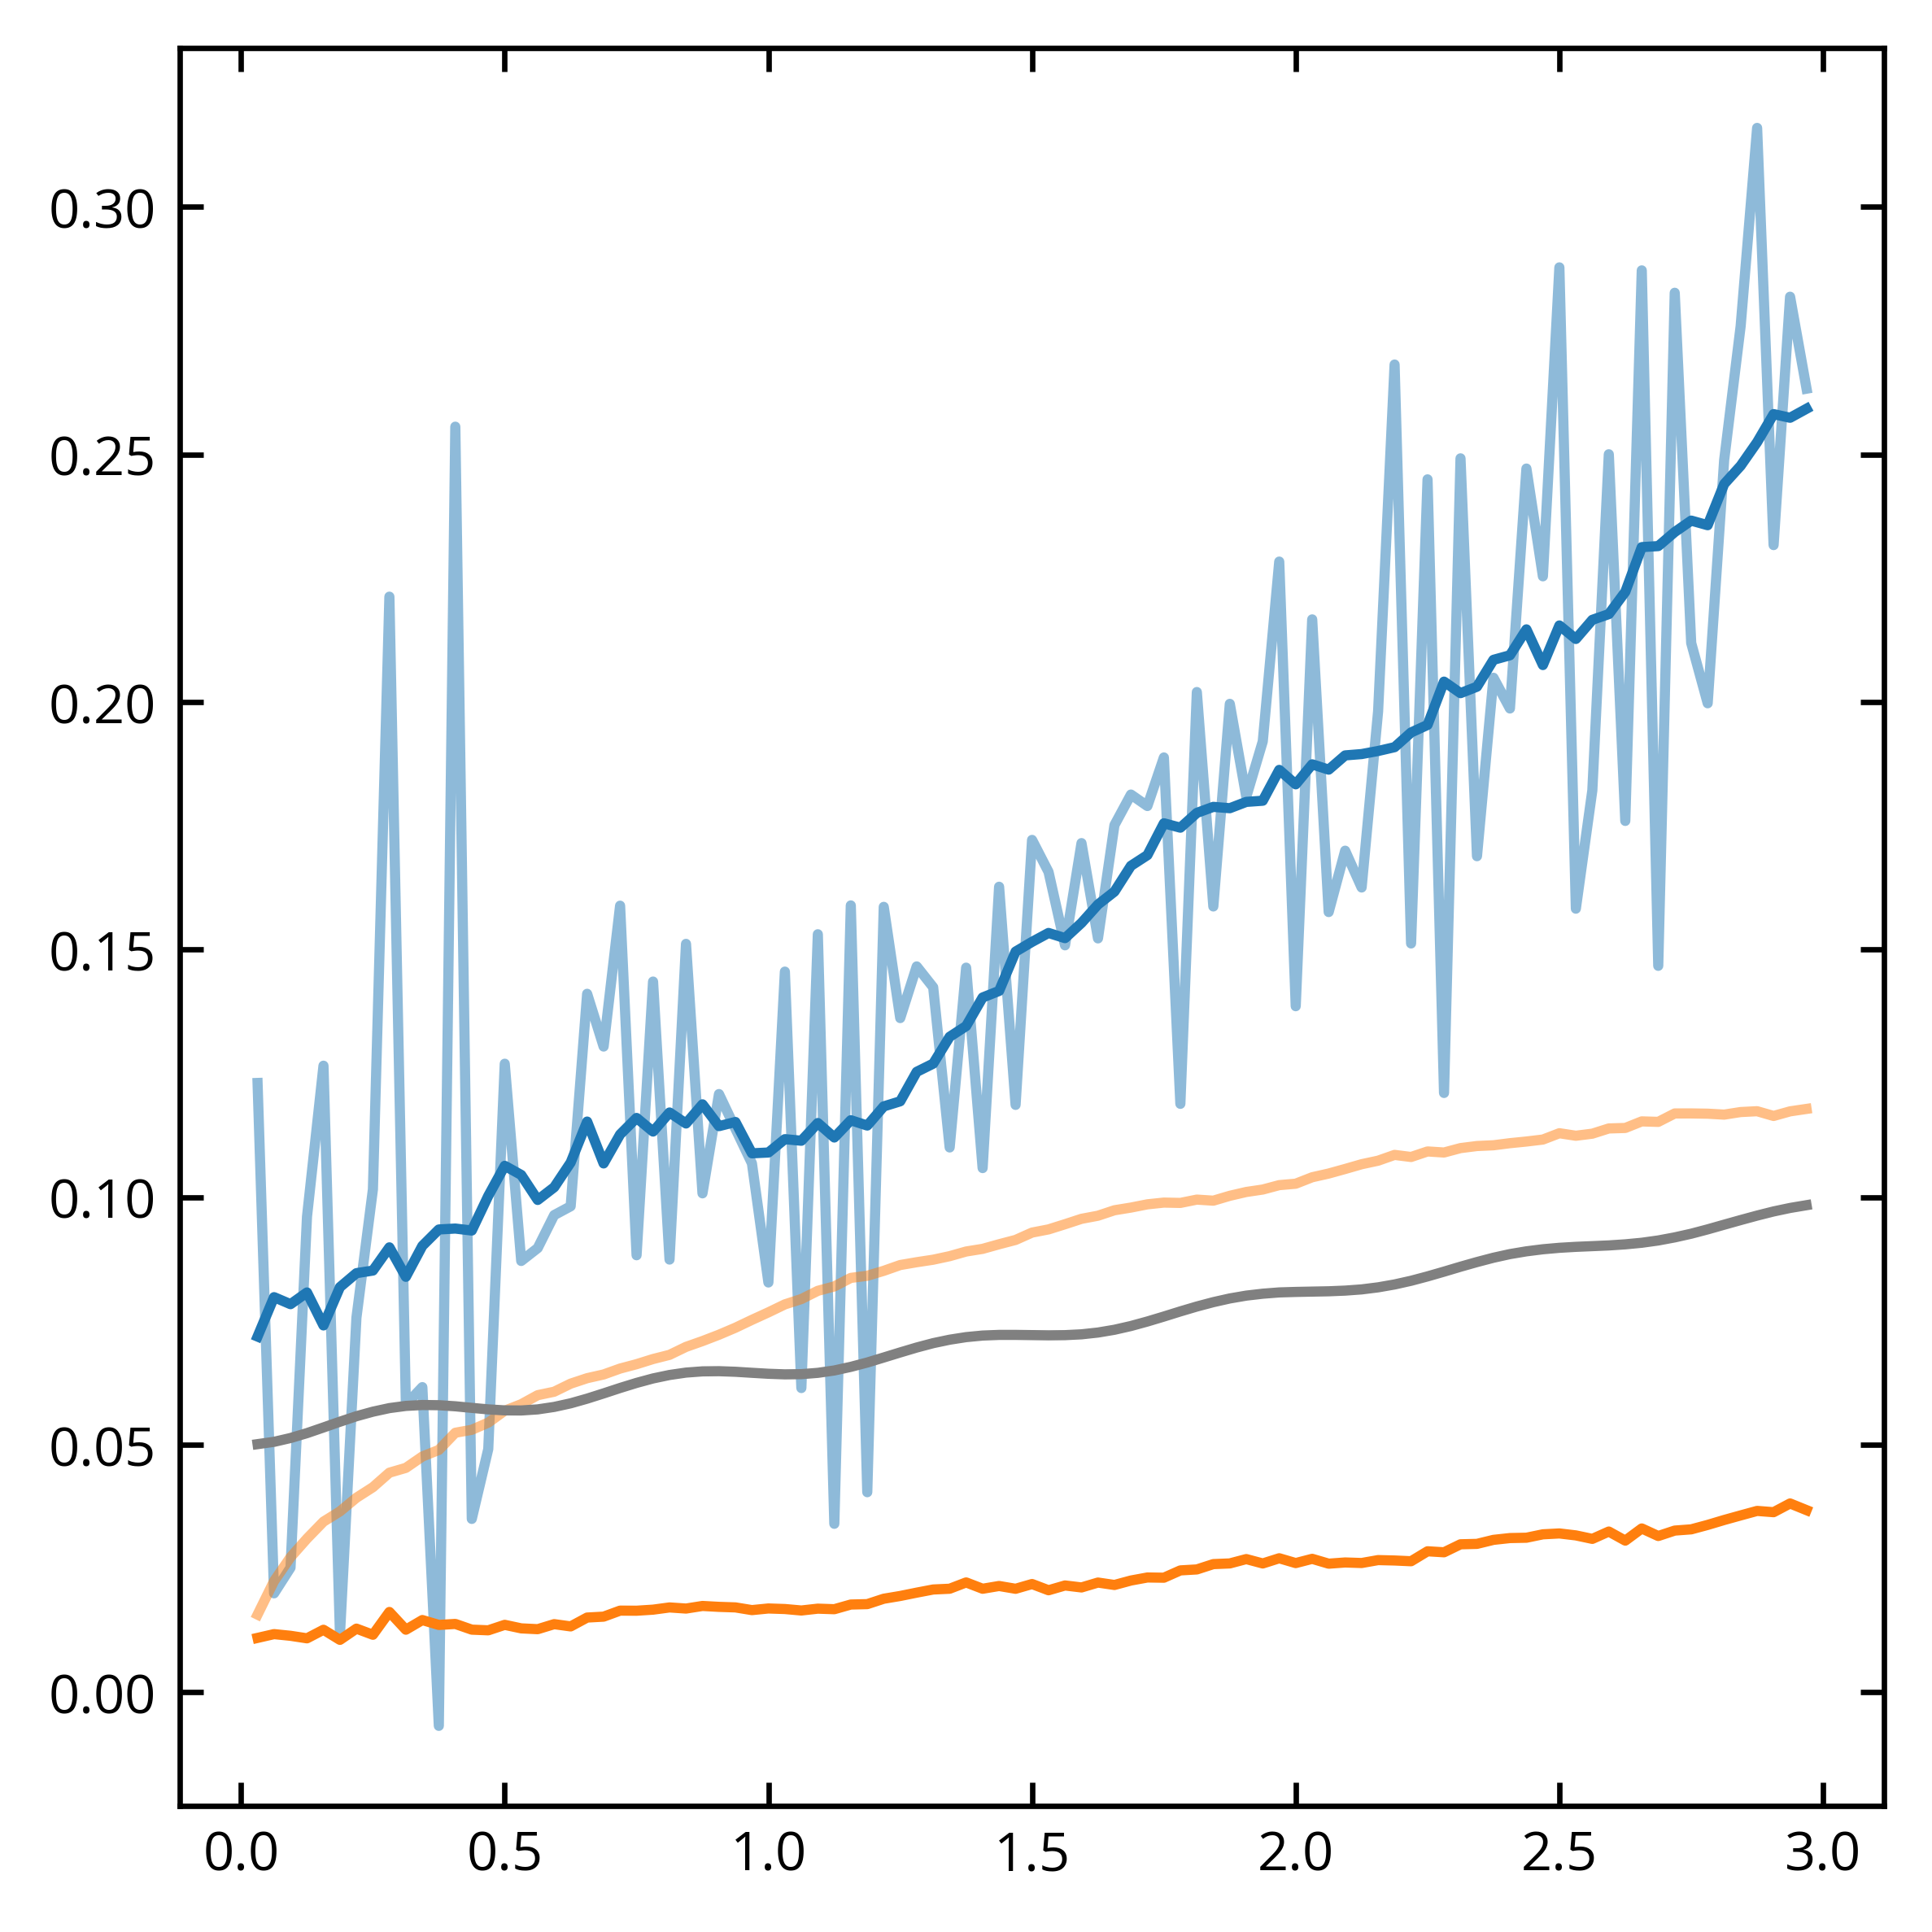

In [404]:
from scipy.ndimage.filters import uniform_filter1d
S_taunu_w_ensem = np.array(S_taunu_w_ensem)
plt.plot(t, (S_p_ensem+S_taunu_w_ensem)/case.wave.c/tau0, label='p', alpha=0.5)
plt.plot(t, np.array(S_taunu_d_ensem)/case.wave.c/tau0, label='p', alpha=0.5)
# plt.plot(t, S_p_err_ensem, label='p', c='C0', alpha=0.2, lw = 4)
plt.plot(t, (uniform_filter1d(S_p_ensem, size=16)+S_taunu_w_ensem)/case.wave.c/tau0, c='C0')
plt.plot(t, (S_taunu_w_ensem)/case.wave.c/tau0, c='C1')

plt.plot(t, ak, c='gray')
# plt.plot(t, S_taunu_ensem, label='tau_nu', c='C1')
# plt.plot(t, S_taunu_err_ensem, label='p', alpha=0.2, lw = 4, c='C1')

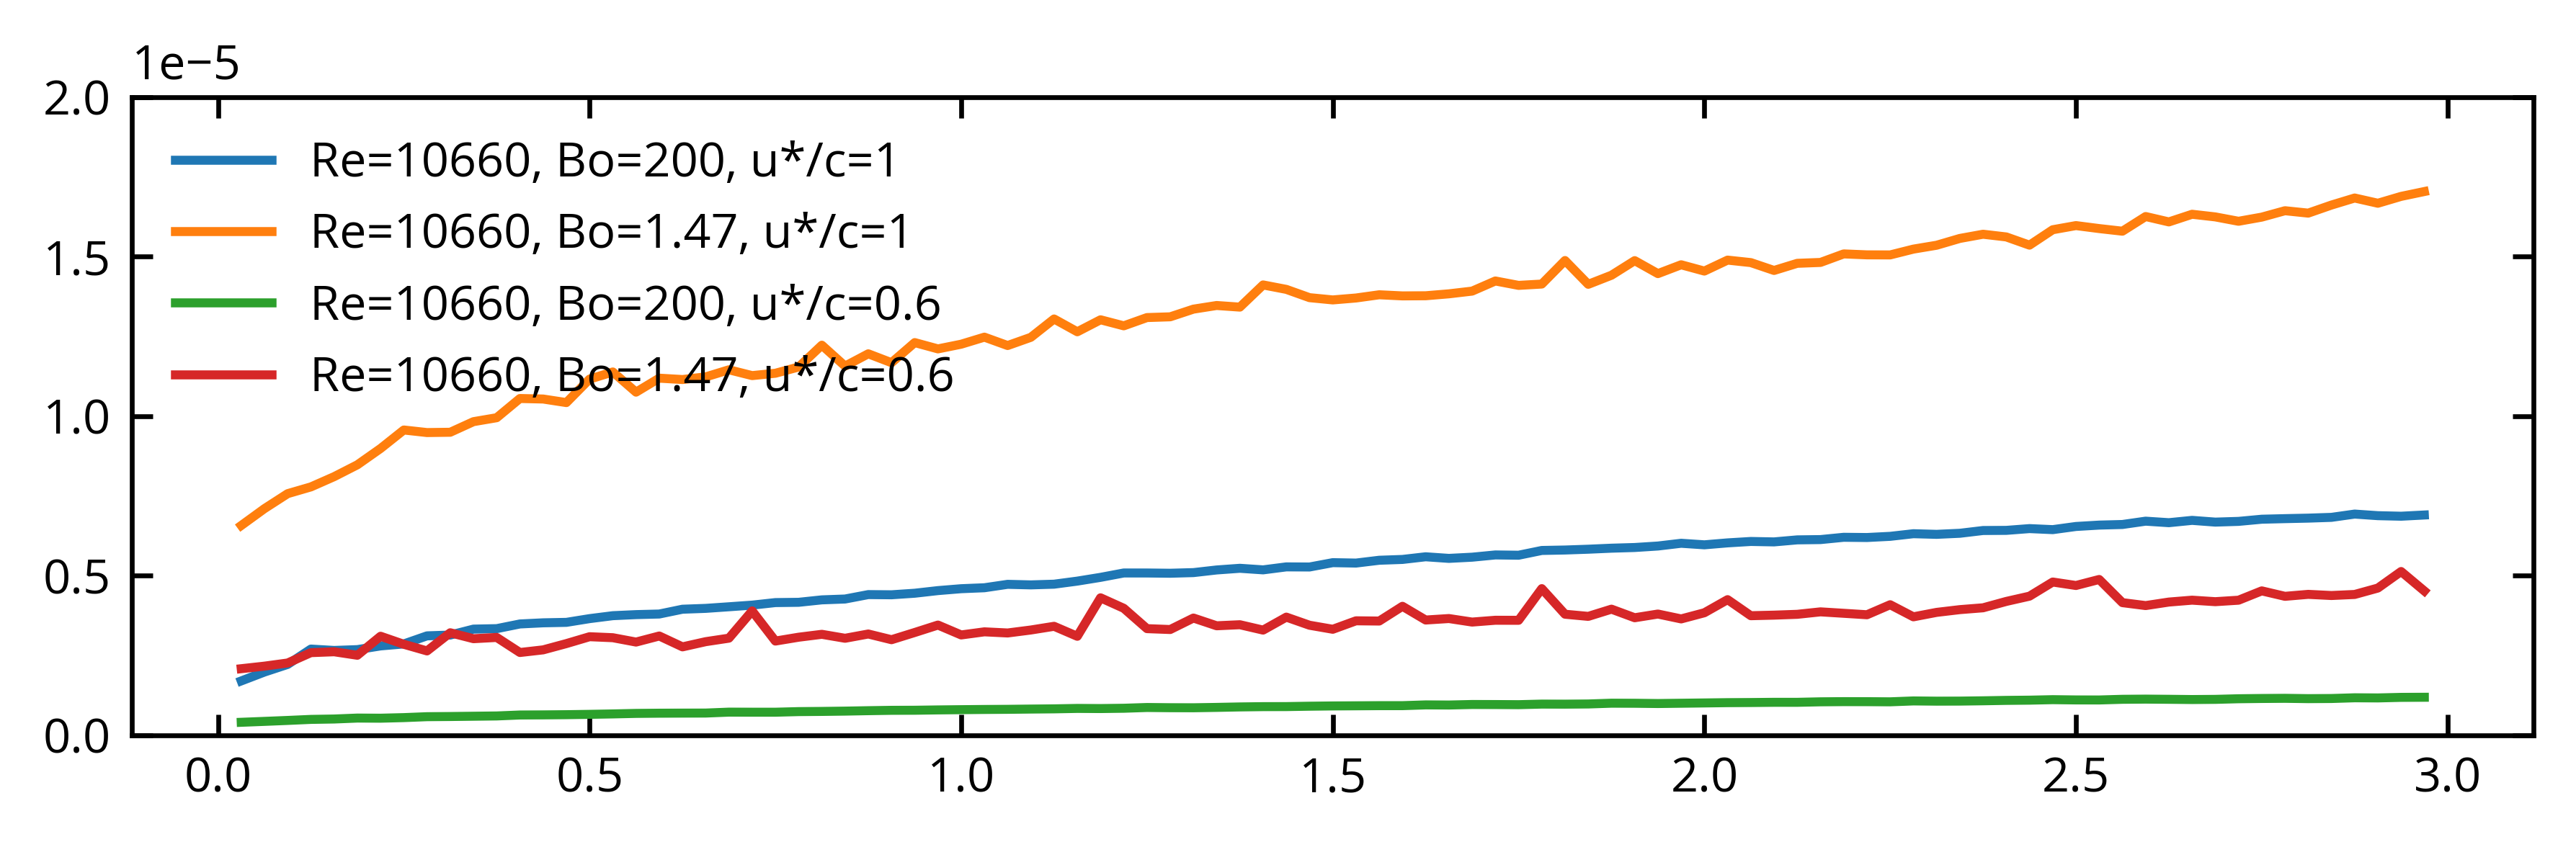

In [400]:
fig = plt.figure(figsize=[6,2])

for case in (case1,case2,case3,case4):
    data,exists = readin(case.path + '/dissipation.dat', table_delimiter = ',', 
                           table_headers = ['t', 'diss'], skipn = 1)
    if exists:
        diss = np.array(data.diss)
    plt.plot(data.t[1:], diss[1:], label='Re=%g, Bo=%g, u*/c=%g' %(case.Re,case.Bo,case.ustar))

plt.ylim([0,0.00002]); plt.legend()

No handles with labels found to put in legend.


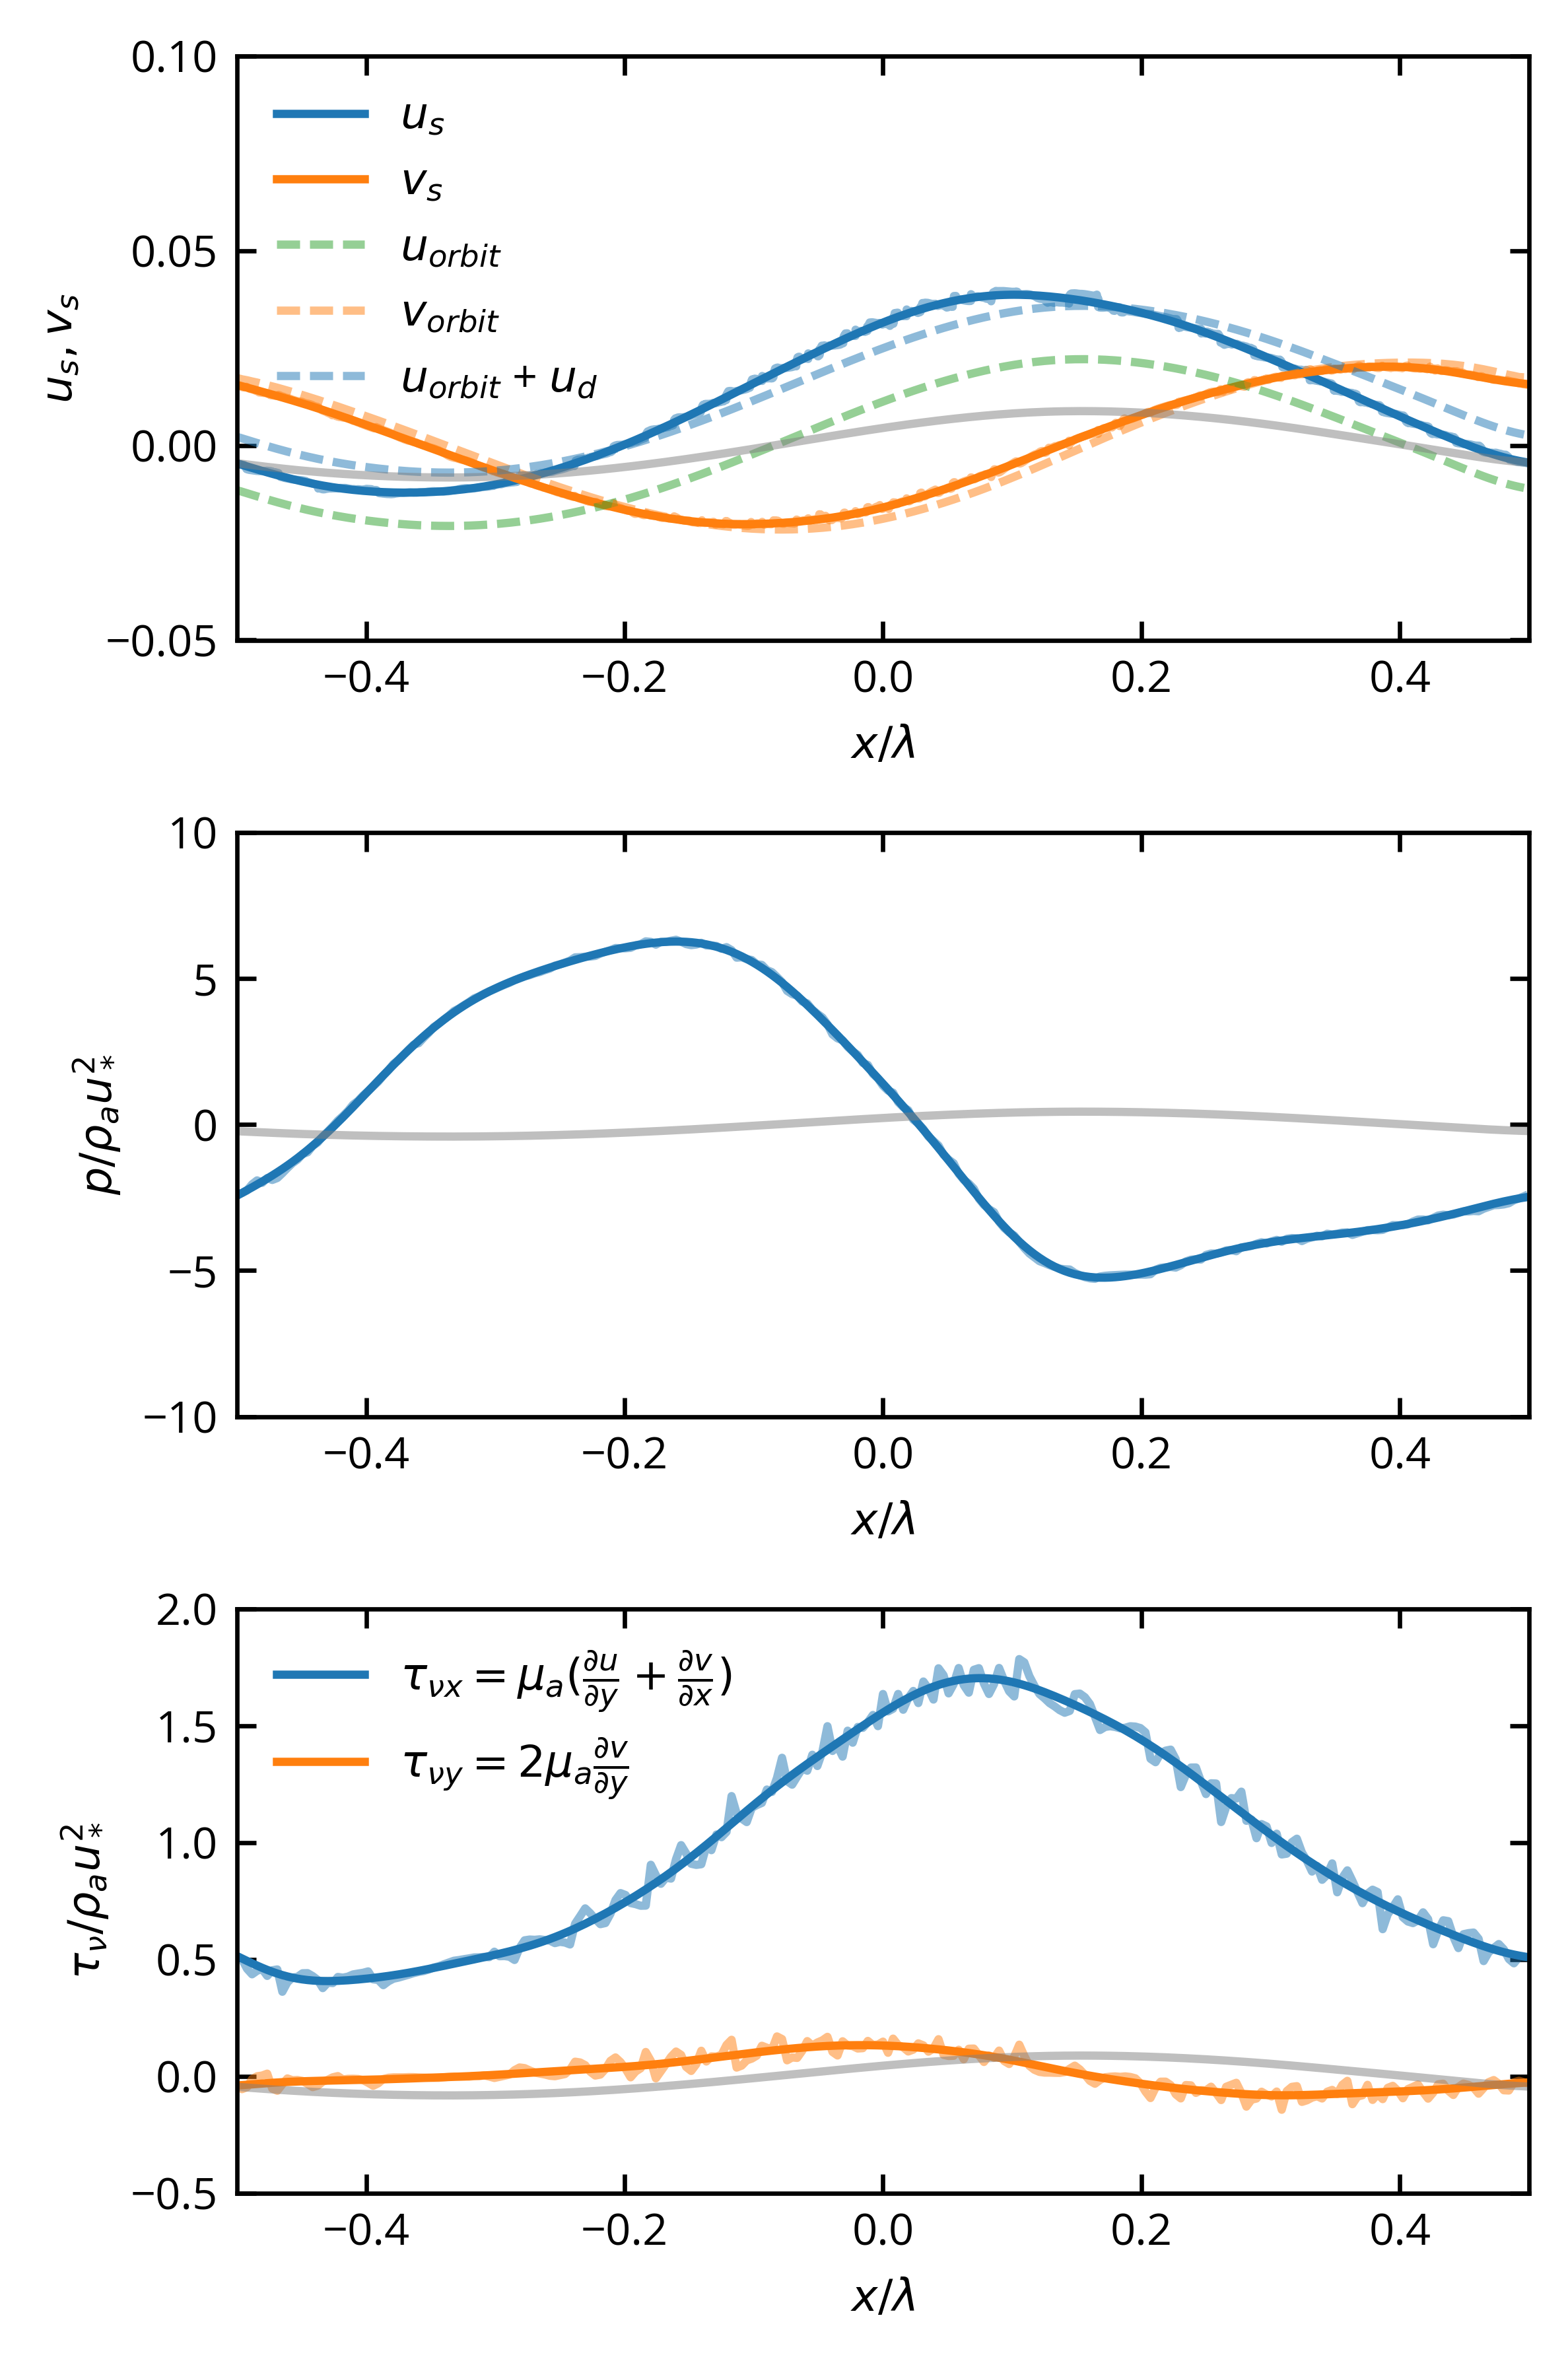

In [406]:
interface_ensem[4].vis()

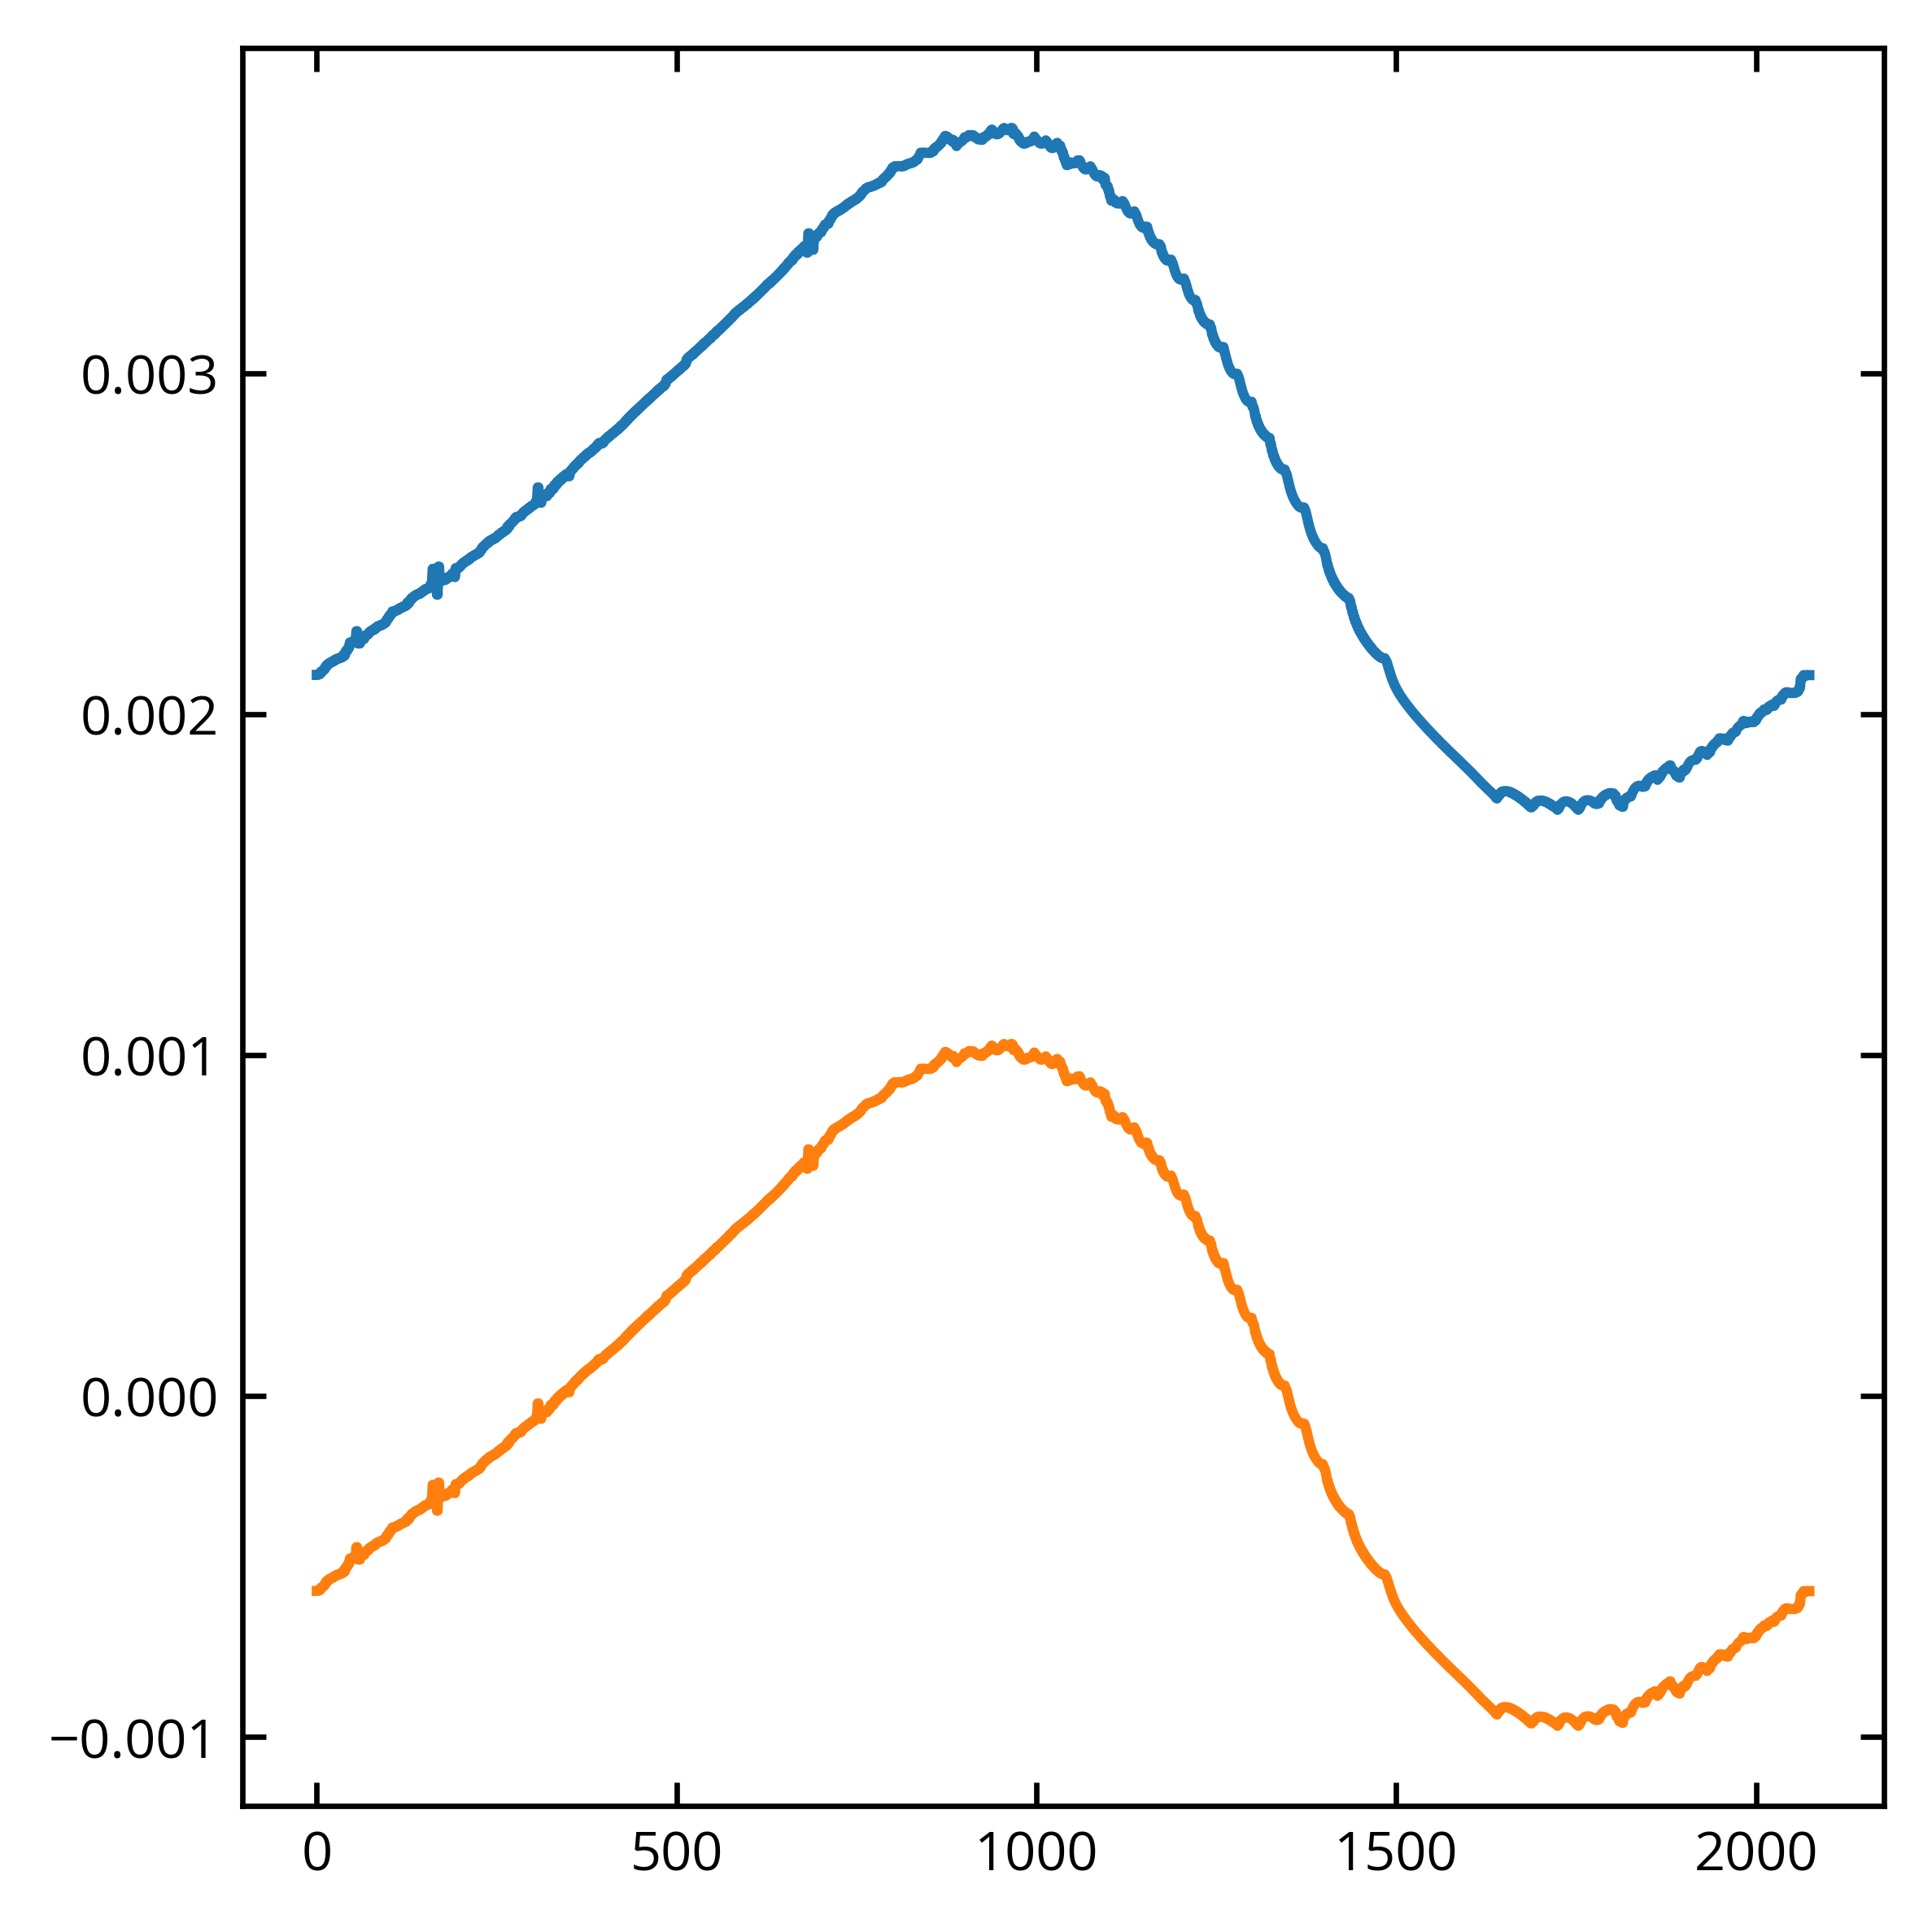

In [410]:
plt.plot(interface_ensem[40].pdata)
plt.plot(interface_ensem[40].pdata - np.average(interface_ensem[40].pdata))